In [1]:
# import package

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import StepLR

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy

In [2]:
import os
path2train = '/STL10/train'
if not os.path.exists(path2train):
    os.mkdir(path2data)

path2test = '/STL10/test'
if not os.path.exists(path2test):
    os.mkdir(path2data)

train_dataset = datasets.STL10('/STL10/train',split='train', download=True, transform = transforms.ToTensor())
test_dataset = datasets.STL10('/STL10/test',split='test', download=True, transform = transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


- 다운받은 Dataset을 학습시키기 위해 dataset image의 size를 바꿔주고, Normalize 해준다.

In [3]:
import numpy as np
def get_mean(dataset):
    meanRGB = [np.mean(image.numpy(), axis = (1,2)) for image,_ in dataset]
    meanR = np.mean([m[0] for m in meanRGB])
    meanG = np.mean([m[1] for m in meanRGB])
    meanB = np.mean([m[2] for m in meanRGB])
    return [meanR,meanG,meanB]

def get_std(dataset):
    stdRGB = [np.std(image.numpy(), axis = (1,2)) for image,_ in dataset]
    stdR = np.std([s[0] for s in stdRGB])
    stdG = np.std([s[1] for s in stdRGB])
    stdB = np.std([s[2] for s in stdRGB])
    return [stdR,stdG,stdB]


In [4]:
import numpy as np
def get_mean(dataset):
    meanRGB = [np.mean(image.numpy(), axis = (1,2)) for image,_ in dataset]
    meanR = np.mean([m[0] for m in meanRGB])
    meanG = np.mean([m[1] for m in meanRGB])
    meanB = np.mean([m[2] for m in meanRGB])
    return [meanR,meanG,meanB]

def get_std(dataset):
    stdRGB = [np.std(image.numpy(), axis = (1,2)) for image,_ in dataset]
    stdR = np.std([s[0] for s in stdRGB])
    stdG = np.std([s[1] for s in stdRGB])
    stdB = np.std([s[2] for s in stdRGB])
    return [stdR,stdG,stdB]


In [5]:
train_transforms = transforms.Compose([transforms.Resize((128,128)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(get_mean(train_dataset),get_std(train_dataset))])

test_transforms = transforms.Compose([transforms.Resize((128,128)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(get_mean(test_dataset),get_std(test_dataset))])

In [6]:
train_dataset.transform = train_transforms
test_dataset.transform = test_transforms

- train과 test Dataset을 모델에 적용하기 위해서 DataLoader에 dataset을 올려준다.

In [7]:
# create DataLoader
train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dl = DataLoader(test_dataset, batch_size=32, shuffle=True)

- 아래 코드를 통해 Loader에 Dataset이 잘 올려졌음을 확인할 수 있다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image indices: [ 235 3980  905 2763]


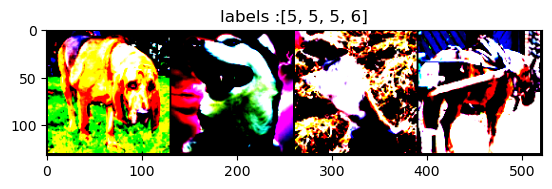

In [8]:
# display sample images 
def show(img, y=None, color=True):
    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1,2,0))
    plt.imshow(npimg_tr)

    if y is not None:
        plt.title('labels :' + str(y))

np.random.seed(1)
torch.manual_seed(1)

grid_size = 4
rnd_inds = np.random.randint(0, len(train_dataset), grid_size)
print('image indices:',rnd_inds)

x_grid = [train_dataset[i][0] for i in rnd_inds]
y_grid = [train_dataset[i][1] for i in rnd_inds]

x_grid = utils.make_grid(x_grid, nrow=grid_size, padding=2)

show(x_grid, y_grid)

# Resnet 구현

- ResNet 논문에 의하면 각 Block단위로 shortcut connection이 연결되어 있기 때문에 Block 모듈을 먼저 생성해준다.
- Block은 ResNet에 활용되는 layer의 수에 따라 다르기 때문에 2가지 종류의 Block을 만들어준다.
- Residual funcion은 기존 plain한 covolution layer들이고, shortcut function이 Residual Learning이 가능하게 해주는 connection 부분이다.

In [97]:
class BasicBlock(nn.Module):
    expansion=1
    def __init__(self,in_channels,out_channels,stride=1):
        super(BasicBlock,self).__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=stride,padding=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLu(),
            nn.Conv2d(out_channels,out_channels*BasicBlock.expansion,kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(out_channels*BasicBlock.expansion),
        )

        if stride != 1 or in_channels != out_channels * BasicBlock.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*BasicBlock.expansion))
        else:
            self.shortcut = nn.Sequential()
        
        self.relu = nn.ReLU()

    def forward(self,x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

In [98]:
class BottleNeck(nn.Module):
    expansion=4
    def __init__(self,in_channels,out_channels,stride=1):
        super().__init__()
        
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=stride,padding=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels,out_channels*BottleNeck.expansion,kernel_size=1,stride=1,bias=False),
            nn.BatchNorm2d(out_channels*BottleNeck.expansion),
        )

#논문에서 shortcut connection을 연결할 떄 input과 output dimension를 고려하여 identity mapping과 projection 두 종류의 Residual Network를 사용해주었다.
        if stride != 1 or in_channels != BottleNeck.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion))
        else:
            self.shortcut = nn.Sequential()
            
        self.relu = nn.ReLU()
        

    def forward(self,x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

- 논문에서 Block을 통과할 때마다 image size는 절반이되고, filter의 수는 4배씩 늘리는 구조를 제안했기 때문에 이 부분을 맞춰주는데 조금 신경을 써줘야 했다.
- 그래서 stride를 늘려야 하는 타이밍, input size와 output size가 잘 연결될 수 있도록 make layer 함수에 반복문과 조건문을 섞어서 활용했다.

In [99]:
stride=2
num_blocks=6
strides = [stride] + [1] * (num_blocks - 1)

In [100]:
strides

[2, 1, 1, 1, 1, 1]

In [106]:
class ResNet(nn.Module):
    def __init__(self,Block,num_block,num_classes=10):
        super().__init__()
        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=7,stride=2,padding=3,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
        )
        self.conv2 = self.make_layer(Block,num_block[0],64,stride=1)
        self.conv3 = self.make_layer(Block,num_block[1],128,stride=2)
        self.conv4 = self.make_layer(Block,num_block[2],256,stride=2)
        self.conv5 = self.make_layer(Block,num_block[3],512,stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*Block.expansion,num_classes)
        
    #Block이 반복되면서 input,output size에 변동이 생겨 이를 연결해주는 과정
    def make_layer(self,Block,num_block,out_channels,stride):
        layers=[]
        for i in range(num_block):
            if i == 0:
                st=stride #block이 시작할 때마다 stride를 변경하여 input size 조정
                
            else: 
                st=1
            layers.append(Block(self.in_channels,out_channels,stride=st))
            self.in_channels=out_channels*Block.expansion
        
        return nn.Sequential(*layers)

    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return x

#### ResNet50 구현 완료

In [107]:
def resnet50():
    return ResNet(BottleNeck, [3,4,6,3])

In [108]:
from torchvision import models
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [109]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet50().to(device)
x = torch.randn(3, 3, 224, 224).to(device)
output = model(x)
print(output.size())

torch.Size([3, 10])


In [110]:
summary(model, (3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

### ResNet50 학습

In [22]:
lr = 0.001 #learning rate
num_epochs = 10 #학습할 epoch 수
optimizer = optim.Adam(model.parameters(), lr=lr) #Gradient Descent 에 적용할 Activation 함수
loss_function = nn.CrossEntropyLoss().to(device) #model의 성능을 측정하고 학습 현황을 보여줄 목적함수

In [32]:
params = {
    'num_epochs':num_epochs,
    'optimizer':optimizer,
    'loss_function': loss_function,
    'train_dataloader':train_dl,
    
    'test_dataloader': val_dl,
    'device':device
}

In [33]:
def train(model,params):
    loss_function=params['loss_function']
    train_dataloader=params['train_dataloader']
    test_dataloader=params['test_dataloader']
    device=params['device']

    #epoch 횟수 만큼 학습
    for epoch in range(0,num_epochs): 
        for i,data in enumerate(train_dataloader,0):
            inputs,labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            #이전 배치의 가중치 초기화
            optimizer.zero_grad()

            #feedforward 그리고 backpropagation
            output = model(inputs)
            train_loss = loss_function(output,labels)
            train_loss.backward()
            #가중치 업데이트
            optimizer.step()

        total = 0
        correct = 0
        accuracy = []
        for i,data in enumerate(test_dataloader,0):
            inputs,labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            _, predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_loss = loss_function(outputs,labels)
            accuracy.append(100*correct/total)

        print('Epoch: %d/%d, Train loss: %.6f, Test loss: %.6f, Accuracy %.2f' % (epoch+1,num_epochs,train_loss.item(),test_loss.item(),100*correct/total))

In [34]:
train(model, params)

Epoch: 1/10, Train loss: 1.590493, Test loss: 1.675134, Accuracy 30.32
Epoch: 2/10, Train loss: 1.793931, Test loss: 1.701716, Accuracy 33.90
Epoch: 3/10, Train loss: 1.561056, Test loss: 1.488432, Accuracy 36.64
Epoch: 4/10, Train loss: 2.202175, Test loss: 1.635617, Accuracy 37.55
Epoch: 5/10, Train loss: 1.804091, Test loss: 1.603844, Accuracy 38.66
Epoch: 6/10, Train loss: 1.347402, Test loss: 1.274734, Accuracy 42.76
Epoch: 7/10, Train loss: 1.206002, Test loss: 1.394682, Accuracy 46.69
Epoch: 8/10, Train loss: 1.721331, Test loss: 1.095759, Accuracy 50.56
Epoch: 9/10, Train loss: 2.846714, Test loss: 1.173069, Accuracy 50.70
Epoch: 10/10, Train loss: 1.338979, Test loss: 1.155311, Accuracy 50.29
